This notebook demonstrates Kausal framework on Coupled Rossler dynamics.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
from torch.nn import functional as F
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm, colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from kausal.generator import coupled_rossler
from kausal.koopman import Kausal
from kausal import stats
from kausal.observables import RandomFourierFeatures, MLPFeatures


# 1. Generate dynamics 
First, we are going to generate the dynamics of Coupled Rossler as described in https://arxiv.org/pdf/2410.10103.
Some analysis are then performed, including reproducing Figure 1b.

### 1a. Specify parameters, ICs, timestepping

In [3]:
# Time span
t0, t1 = 0.0, 10.0
dt = 0.01
steps = int((t1 - t0) / dt)

# Parameters
phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters

# Initial condition (eye-ball from the paper)
initial_state = torch.tensor([1.0, -2.0, 0.0, 0.0, 0.0, 0.0])

# Coupling coefficients 
# (causal direction: Omega 2 --> Omega 1; but NOT Omega 1 --> Omega 2)
c2 = 0


### 1b. Integrate forward

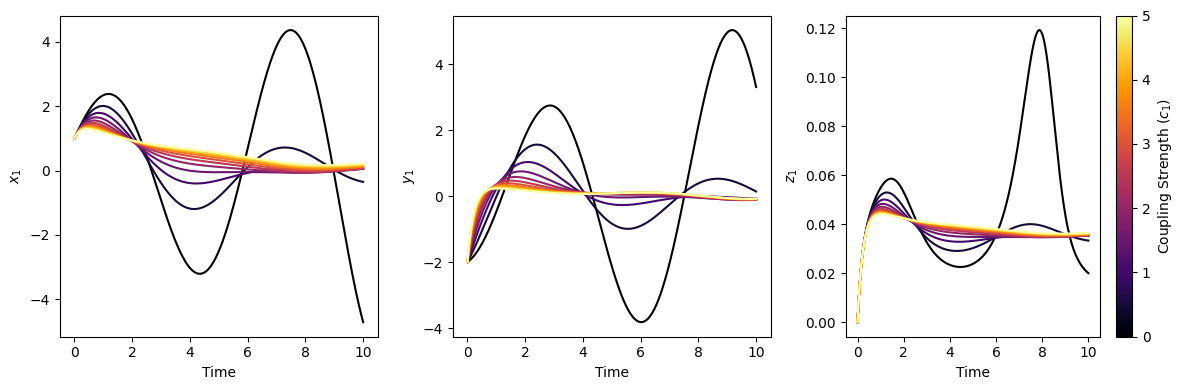

In [4]:
# Integration
solver = torchdiffeq.odeint

# Create figure
f, ax = plt.subplots(1, 3, figsize=(12, 4))

# Generate color map and normalize
c1_values = torch.linspace(0, 5, 11)  # Coupling strength values
cmap = cm.inferno  # Inferno colormap
norm = mcolors.Normalize(vmin=c1_values.min(), vmax=c1_values.max())  # Normalize color scale

# Define the dynamics solver
def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: coupled_rossler(t, state, params)
    
    solution = solver(
        dynamics,
        initial_state,
        t,
        method='dopri5',
        options={'max_num_steps': 100000}
    )
    return t, solution

# Iterate over coupling values and solve the system
for c1 in c1_values:
    params = (phi1, phi2, a, b, d, c1, c2)

    # Solve the system
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

    # Extract results (divided into omega_1, omega_2)
    omega_1 = solution.T[:3]
    omega_2 = solution.T[3:]

    # Get the color from the colormap
    color = cmap(norm(c1.numpy()))

    # Plot the results
    ax[0].plot(t.numpy(), omega_1[0].numpy(), color=color)
    ax[1].plot(t.numpy(), omega_1[1].numpy(), color=color)
    ax[2].plot(t.numpy(), omega_1[2].numpy(), color=color)

# Add colorbar to the last axis
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the ScalarMappable
cbar = f.colorbar(sm, ax=ax[-1], location='right', pad=0.05)
cbar.set_label(r"Coupling Strength ($c_1$)")

# Add labels
for i, var in enumerate([r"$x_1$", r"$y_1$", r"$z_1$"]):
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(var)

plt.tight_layout()
plt.show()
f.savefig("docs/coupled_rossler.png", dpi=300, bbox_inches="tight");


# 2. Causal Koopman

This section describes several causal algorithms based on Koopman operator framework, as described in https://arxiv.org/pdf/2410.10103. In particular, there are two causal effect analyses that we are interested in:

1. __Temporal shifts__: estimate causal effect by increasing temporal dependency (shift). 
2. __Conditional forecast__: estimate causal effect by estimating the conditional forecasts between marginal and joint models.

In [5]:
# Let's first generate the dynamics
t0, t1 = 0.0, 40.0
dt = 0.01
steps = int((t1 - t0) / dt)
n_train = int(0.8 * steps)

phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters
c1, c2 = 0.5, 0 # Coupling term
params = (phi1, phi2, a, b, d, c1, c2)

# Solve the system
t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

# Extract results (divided into omega_1, omega_2)
omega_1 = solution.T[:3] # True effect variables
omega_2 = solution.T[3:] # True cause variables


### 2a. Causal dependence with increasing shifts

Expected behaviors:
1. __True causal relationship__: Increasing causal 'error' between the marginal and joint models.
2. __False causal relationship__: Low, stationary causal 'error' between the marginal and joint models.

Here, we evaluate the temporal dependency analysis, primarily to reproduce Figure 2.

In [6]:
# Initialize Kausal object, where we can pass in the cause-effect variables to be analyzed

## Test C --> E (true causal direction)
causal_koopman = Kausal(
    cause = omega_2,
    effect = omega_1,
)

## Test E --> C (false causal direction)
noncausal_koopman = Kausal(
    cause = omega_1,
    effect = omega_2
)


In [7]:
# Causal effect is estimated through the (marginal - joint) loss
time_shifts = torch.arange(1, 2000, 50)

## 1. Causal effect
causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 2. Non-causal effect
non_causal_effect = noncausal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 3. Hypothesis testing the causal relationship
_, pval = stats.hypothesis_testing(
    causal_effect = causal_effect,
    non_causal_effect = non_causal_effect
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.98it/s]


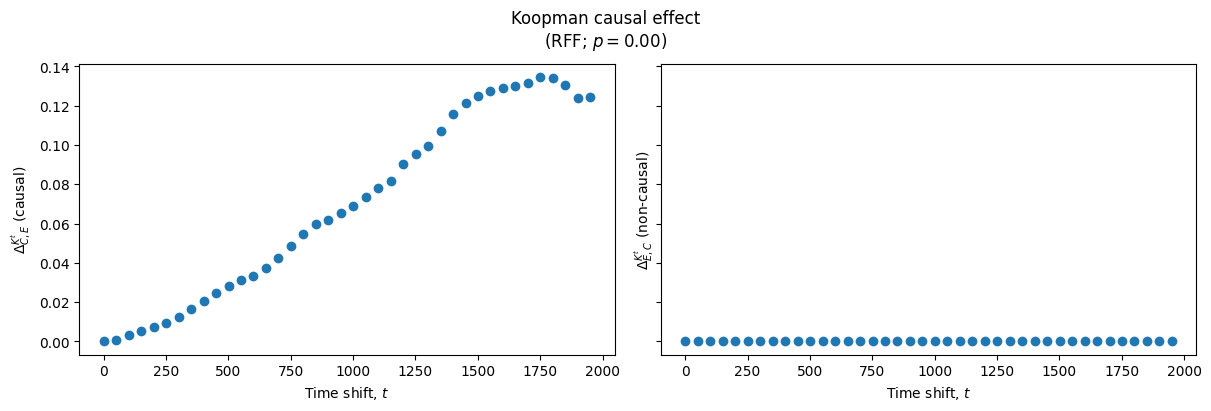

In [8]:
# Plot causal shift
# NOTE: increasing causal error in the true causal direction as time dependency increases.
# NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E

f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, causal_effect)
ax[0].set_xlabel(r'Time shift, $t$')
ax[0].set_ylabel(r'$\Delta^{K^t}_{C,E}$ (causal)')

ax[1].scatter(time_shifts, non_causal_effect)
ax[1].set_xlabel(r'Time shift, $t$')
ax[1].set_ylabel(r'$\Delta^{K^t}_{E,C}$ (non-causal)')

f.suptitle(f'Koopman causal effect\n(RFF; $p = {pval:.2f}$)')
plt.show();


### 2b. Conditional forecast
This is primarily to reproduce the algorithms introduced in Part IV section B, and Figure 4.

Expected behaviors:
1. __True causal relationship__: imperfect match in the marginal model, but better in the joint model since the former lacks the key causal variables.
2. __False causal relationship__: perfect match in the marginal and joint models, since the 'false causal' variables are not useful to make skillful forecast.

In [9]:
# Conditional inference (causal)
# Expected behavior: imperfect match in the marginal model, but better in the joint model.
cause = omega_2
effect = omega_1

omega_marginal, omega_joint = causal_koopman.forecast(
    n_train = n_train,
    time_shift = 1
)


/burg/glab/users/jn2808/.conda/envs/jax/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


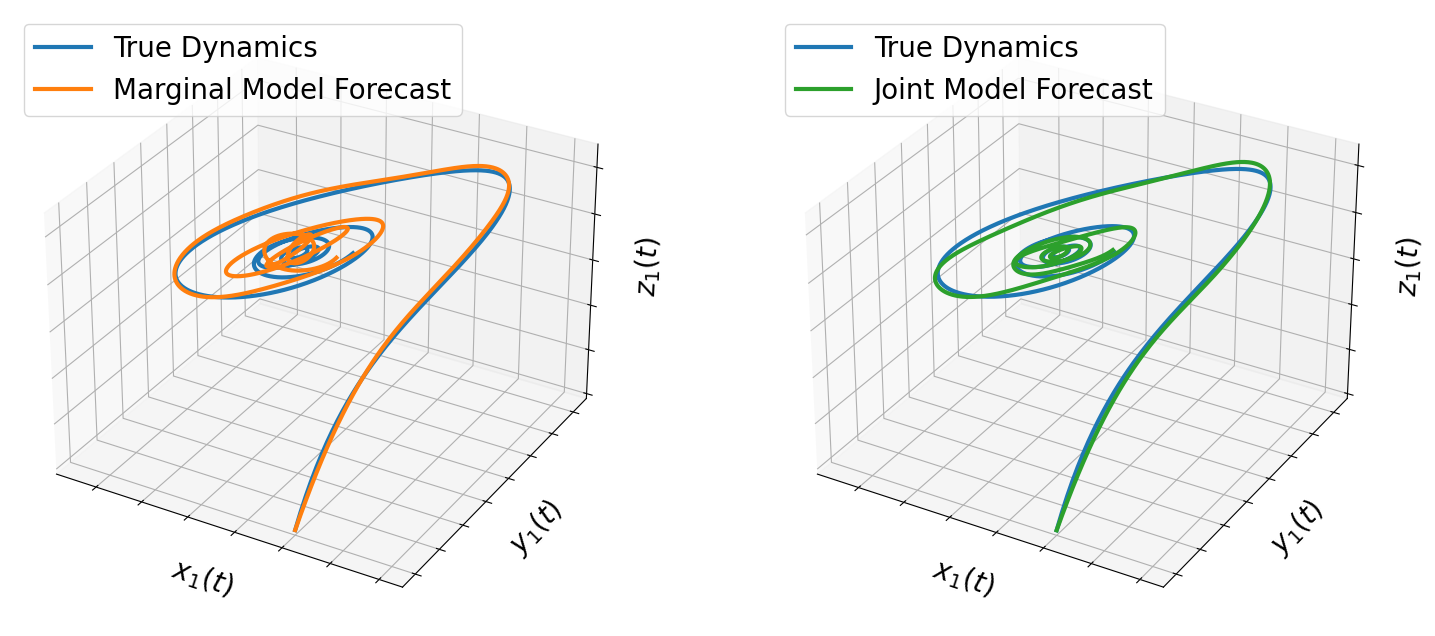

In [10]:
# Select three features for 3D phase space (e.g., indices 0, 1, 2)
x_idx, y_idx, z_idx = 0, 1, 2
time_idx = 3000

# Create subplots for 3D phase space
f = plt.figure(figsize=(18, 8), constrained_layout=True)

# First 3D subplot: True Dynamics vs Marginal Forecast
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax1.plot(effect[x_idx, :time_idx], effect[y_idx, :time_idx], effect[z_idx, :time_idx], label='True Dynamics', color='C0', linewidth=3)
ax1.plot(omega_marginal[x_idx, :time_idx], omega_marginal[y_idx, :time_idx], omega_marginal[z_idx, :time_idx], label='Marginal Model Forecast', color='C1', linewidth=3)
ax1.set_xlabel(rf'$x_1(t)$', size=20)
ax1.set_ylabel(rf'$y_1(t)$', size=20)
ax1.set_zlabel(rf'$z_1(t)$', size=20)
ax1.legend(loc='upper left', fontsize=20)

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

# Second 3D subplot: True Dynamics vs Joint Forecast
ax2 = f.add_subplot(1, 2, 2, projection='3d')
ax2.plot(effect[x_idx, :time_idx], effect[y_idx, :time_idx], effect[z_idx, :time_idx], label='True Dynamics', color='C0', linewidth=3)
ax2.plot(omega_joint[x_idx, :time_idx], omega_joint[y_idx, :time_idx], omega_joint[z_idx, :time_idx], label='Joint Model Forecast', color='C2', linewidth=3)
ax2.set_xlabel(rf'$x_1(t)$', size=20)
ax2.set_ylabel(rf'$y_1(t)$', size=20)
ax2.set_zlabel(rf'$z_1(t)$', size=20)
ax2.legend(loc='upper left', fontsize=20)

ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])

# Adjust tick size
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='z', labelsize=8)

plt.show()
f.savefig("docs/coupled_rossler_forecast_true_rff.png", dpi=300, bbox_inches="tight");


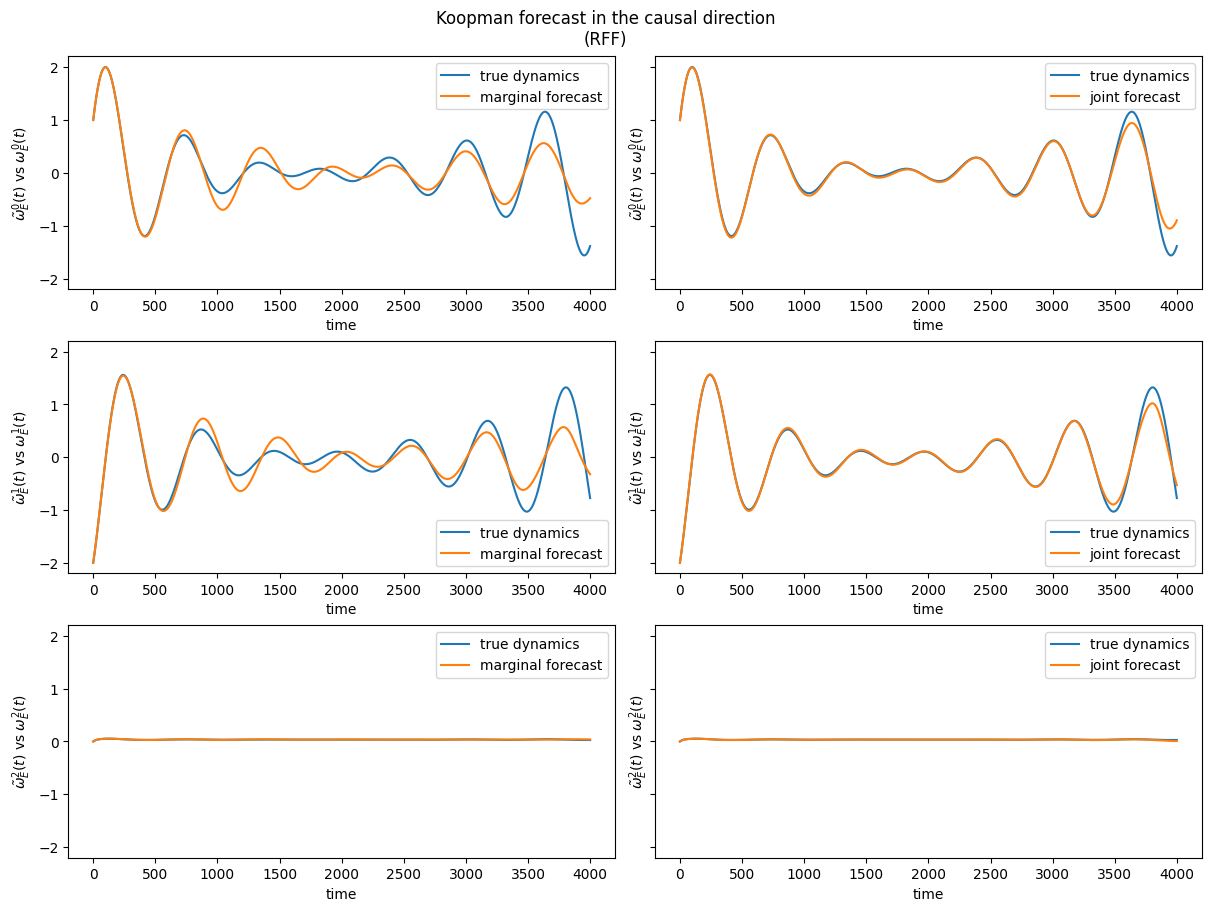

In [11]:
# Plot (conditional inference: causal)
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the causal direction\n(RFF)')
plt.show();


In [12]:
# Conditional inference (non-causal)
# Expected behavior: better match in both the marginal and joint models.
cause = omega_1
effect = omega_2

omega_marginal, omega_joint = noncausal_koopman.forecast(
    n_train = n_train,
    time_shift = 1
)


/burg/glab/users/jn2808/.conda/envs/jax/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


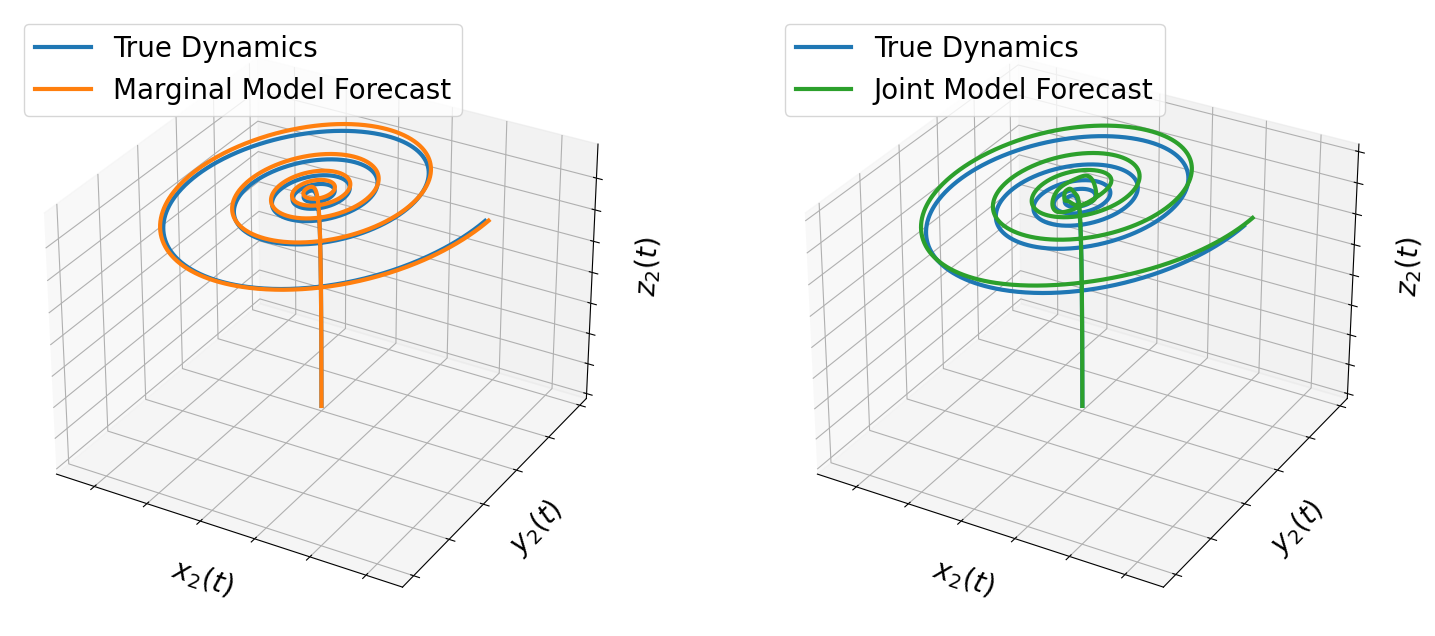

In [13]:
# Select three features for 3D phase space (e.g., indices 0, 1, 2)
x_idx, y_idx, z_idx = 0, 1, 2
time_idx = 3000

# Create subplots for 3D phase space
f = plt.figure(figsize=(18, 8), constrained_layout=True)

# First 3D subplot: True Dynamics vs Marginal Forecast
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax1.plot(effect[x_idx, :time_idx], effect[y_idx, :time_idx], effect[z_idx, :time_idx], label='True Dynamics', color='C0', linewidth=3)
ax1.plot(omega_marginal[x_idx, :time_idx], omega_marginal[y_idx, :time_idx], omega_marginal[z_idx, :time_idx], label='Marginal Model Forecast', color='C1', linewidth=3)
ax1.set_xlabel(rf'$x_2(t)$', size=20)
ax1.set_ylabel(rf'$y_2(t)$', size=20)
ax1.set_zlabel(rf'$z_2(t)$', size=20)
ax1.legend(loc='upper left', fontsize=20)

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

# Second 3D subplot: True Dynamics vs Joint Forecast
ax2 = f.add_subplot(1, 2, 2, projection='3d')
ax2.plot(effect[x_idx, :time_idx], effect[y_idx, :time_idx], effect[z_idx, :time_idx], label='True Dynamics', color='C0', linewidth=3)
ax2.plot(omega_joint[x_idx, :time_idx], omega_joint[y_idx, :time_idx], omega_joint[z_idx, :time_idx], label='Joint Model Forecast', color='C2', linewidth=3)
ax2.set_xlabel(rf'$x_2(t)$', size=20)
ax2.set_ylabel(rf'$y_2(t)$', size=20)
ax2.set_zlabel(rf'$z_2(t)$', size=20)
ax2.legend(loc='upper left', fontsize=20)

ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])

# Adjust tick size
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='z', labelsize=8)

plt.show()
f.savefig("docs/coupled_rossler_forecast_false_rff.png", dpi=300, bbox_inches="tight");


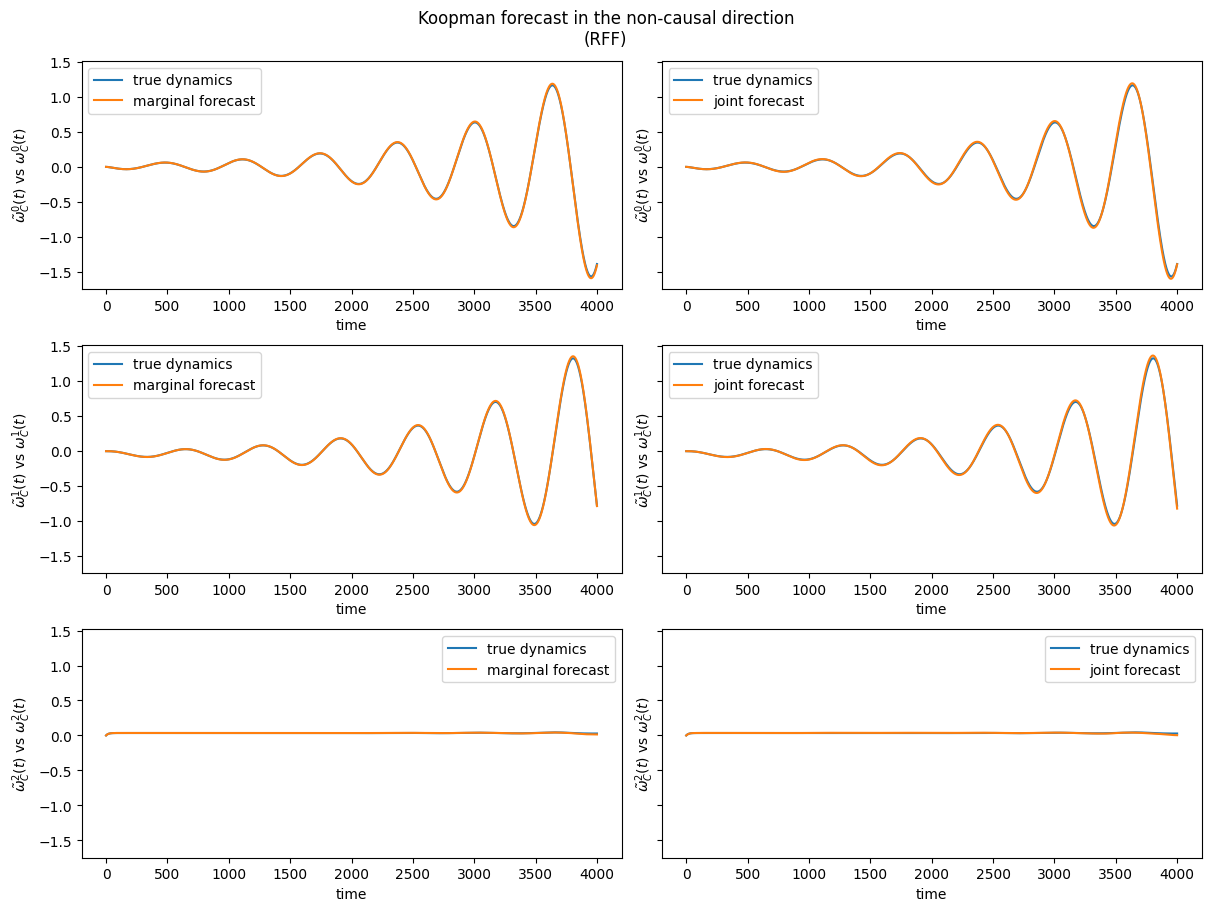

In [14]:
# Plot (conditional inference: non-causal)
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_C^{{{param_id}}}(t)$ vs $\omega_C^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_C^{{{param_id}}}(t)$ vs $\omega_C^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the non-causal direction\n(RFF)')
plt.show();


# 3. Deep Causal Koopman
Now, we use neural network (encoder-decoder __MLP__) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the observables. We perform similar causal analysis as above!

In [15]:
# Initialize Kausal object, where we now specify DL-based observable functions.

# Specify hyperparameters
hidden_channels = [16, 32]

## Test C --> E (true causal direction)
causal_koopman = Kausal(
    marginal_observable = MLPFeatures(in_channels=3, hidden_channels=hidden_channels, out_channels=3),
    joint_observable = MLPFeatures(in_channels=6, hidden_channels=hidden_channels, out_channels=3),
    cause = omega_2,
    effect = omega_1,
)

## Test E --> C (false causal direction)
noncausal_koopman = Kausal(
    marginal_observable = MLPFeatures(in_channels=3, hidden_channels=hidden_channels, out_channels=3),
    joint_observable = MLPFeatures(in_channels=6, hidden_channels=hidden_channels, out_channels=3),
    cause = omega_1,
    effect = omega_2
)


In [16]:
# We first have to fit/train the observable functions
lr = 1e-2
epochs = 500

# 1. Causal direction
marginal_loss_ce, joint_loss_ce = causal_koopman.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = n_train
)

# 2. Non-causal direction
marginal_loss_ec, joint_loss_ec = noncausal_koopman.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = n_train
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 38.88it/s]


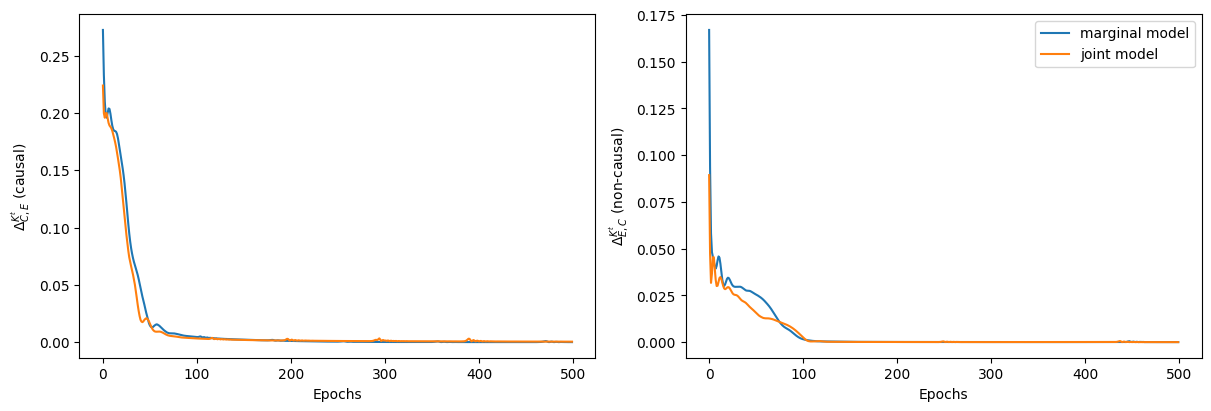

In [17]:
# Plot training losses
f, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
ax[0].plot(marginal_loss_ce, label='marginal model')
ax[0].plot(joint_loss_ce, label='joint model')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel(r'$\Delta^{K^t}_{C,E}$ (causal)')

ax[1].plot(marginal_loss_ec, label='marginal model')
ax[1].plot(joint_loss_ec, label='joint model')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel(r'$\Delta^{K^t}_{E,C}$ (non-causal)')

plt.legend()
plt.show();


### 3a. Causal dependence with increasing shifts

In [18]:
# Causal effect is estimated through the (marginal - joint) loss
time_shifts = torch.arange(1, 2000, 50)

## 1. Causal effect
causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 2. Non-causal effect
non_causal_effect = noncausal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 3. Hypothesis testing the causal relationship
_, pval = stats.hypothesis_testing(
    causal_effect = causal_effect,
    non_causal_effect = non_causal_effect
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  9.10it/s]


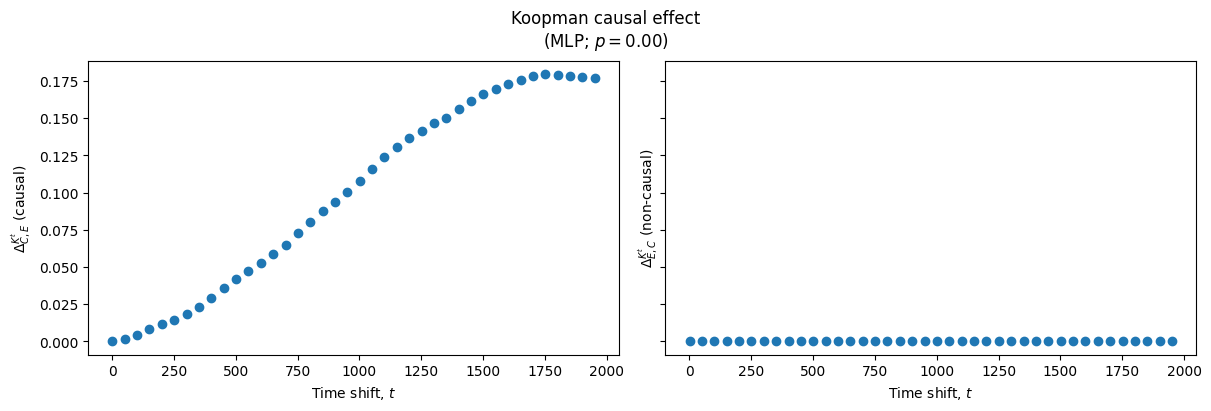

In [19]:
# Plot causal shift
# NOTE: increasing causal error in the true causal direction as time dependency increases.
# NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E

f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, causal_effect)
ax[0].set_xlabel(r'Time shift, $t$')
ax[0].set_ylabel(r'$\Delta^{K^t}_{C,E}$ (causal)')

ax[1].scatter(time_shifts, non_causal_effect)
ax[1].set_xlabel(r'Time shift, $t$')
ax[1].set_ylabel(r'$\Delta^{K^t}_{E,C}$ (non-causal)')

f.suptitle(f'Koopman causal effect\n(MLP; $p = {pval:.2f}$)')
plt.show();


### 3b. Conditioning forecasting

In [20]:
# Conditional inference (causal)
# Expected behavior: imperfect match in the marginal model, but better in joint.
cause = omega_2
effect = omega_1

with torch.no_grad():
    omega_marginal, omega_joint = causal_koopman.forecast(
        n_train = n_train,
        time_shift = 1
    )


/burg/glab/users/jn2808/.conda/envs/jax/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


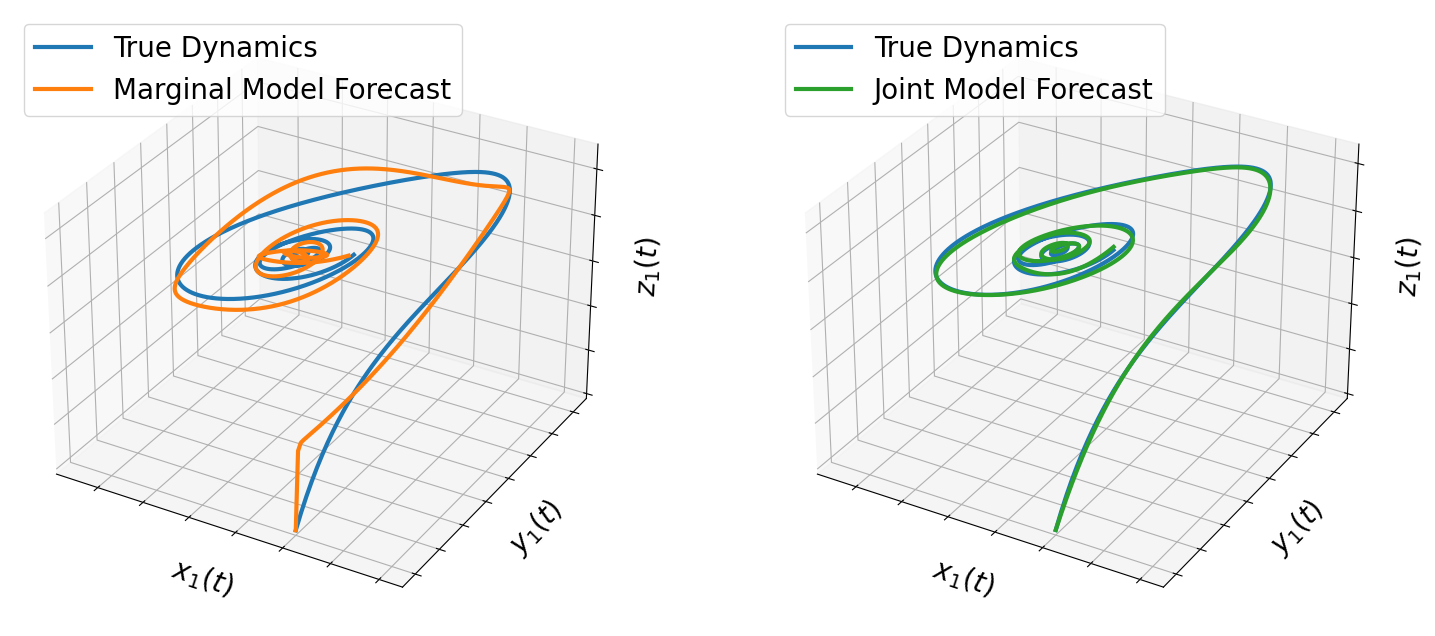

In [21]:
# Select three features for 3D phase space (e.g., indices 0, 1, 2)
x_idx, y_idx, z_idx = 0, 1, 2
time_idx = 3000

# Create subplots for 3D phase space
f = plt.figure(figsize=(18, 8), constrained_layout=True)

# First 3D subplot: True Dynamics vs Marginal Forecast
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax1.plot(effect[x_idx, :time_idx], effect[y_idx, :time_idx], effect[z_idx, :time_idx], label='True Dynamics', color='C0', linewidth=3)
ax1.plot(omega_marginal[x_idx, :time_idx], omega_marginal[y_idx, :time_idx], omega_marginal[z_idx, :time_idx], label='Marginal Model Forecast', color='C1', linewidth=3)
ax1.set_xlabel(rf'$x_1(t)$', size=20)
ax1.set_ylabel(rf'$y_1(t)$', size=20)
ax1.set_zlabel(rf'$z_1(t)$', size=20)
ax1.legend(loc='upper left', fontsize=20)

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

# Second 3D subplot: True Dynamics vs Joint Forecast
ax2 = f.add_subplot(1, 2, 2, projection='3d')
ax2.plot(effect[x_idx, :time_idx], effect[y_idx, :time_idx], effect[z_idx, :time_idx], label='True Dynamics', color='C0', linewidth=3)
ax2.plot(omega_joint[x_idx, :time_idx], omega_joint[y_idx, :time_idx], omega_joint[z_idx, :time_idx], label='Joint Model Forecast', color='C2', linewidth=3)
ax2.set_xlabel(rf'$x_1(t)$', size=20)
ax2.set_ylabel(rf'$y_1(t)$', size=20)
ax2.set_zlabel(rf'$z_1(t)$', size=20)
ax2.legend(loc='upper left', fontsize=20)

ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])

# Adjust tick size
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='z', labelsize=8)

plt.show()
f.savefig("docs/coupled_rossler_forecast_true_mlp.png", dpi=300, bbox_inches="tight");


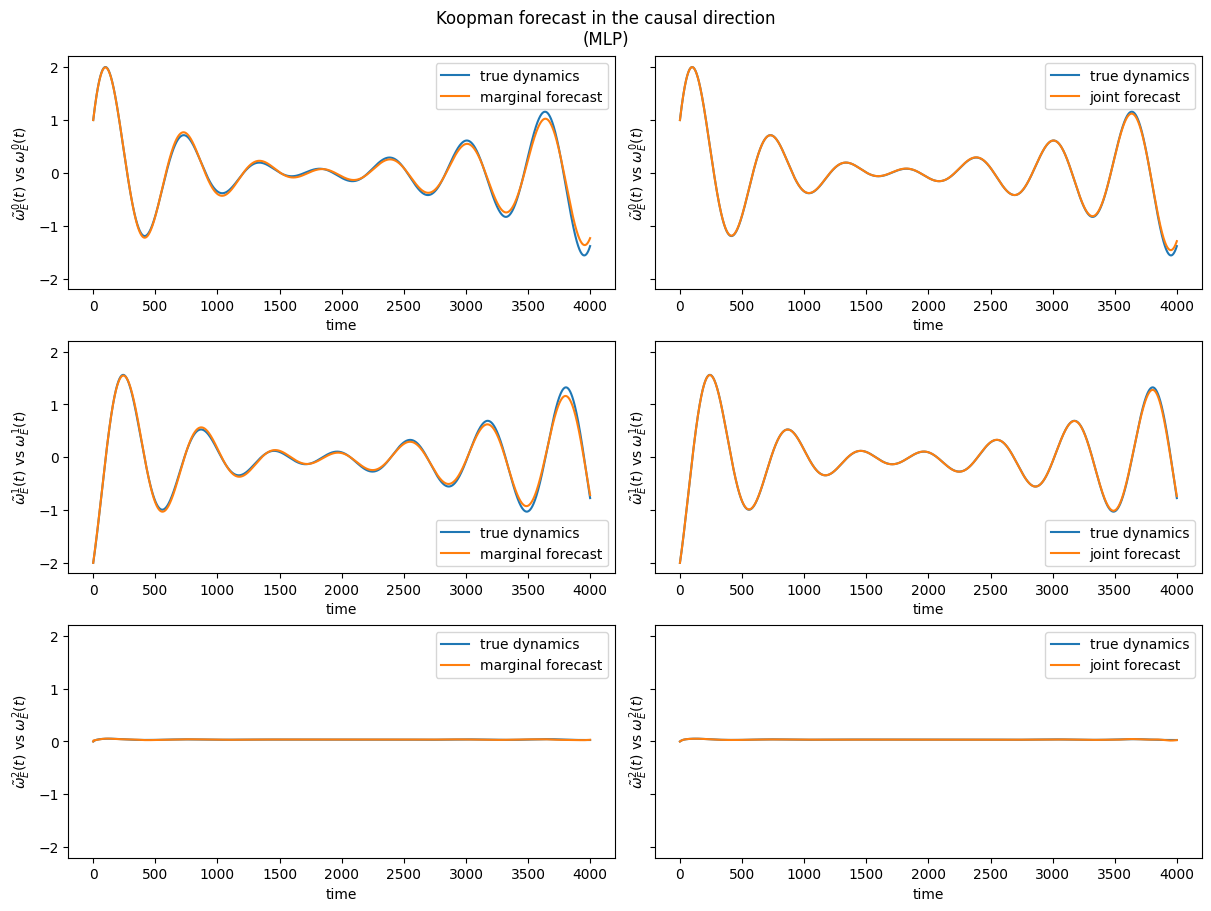

In [22]:
# Plot (conditional inference: causal)
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the causal direction\n(MLP)')
plt.show();


In [23]:
# Conditional inference (non-causal)
# Expected behavior: better match in both marginal and joint models.
cause = omega_1
effect = omega_2

with torch.no_grad():
    omega_marginal, omega_joint = noncausal_koopman.forecast(
        n_train = n_train,
        time_shift = 1
    )


/burg/glab/users/jn2808/.conda/envs/jax/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


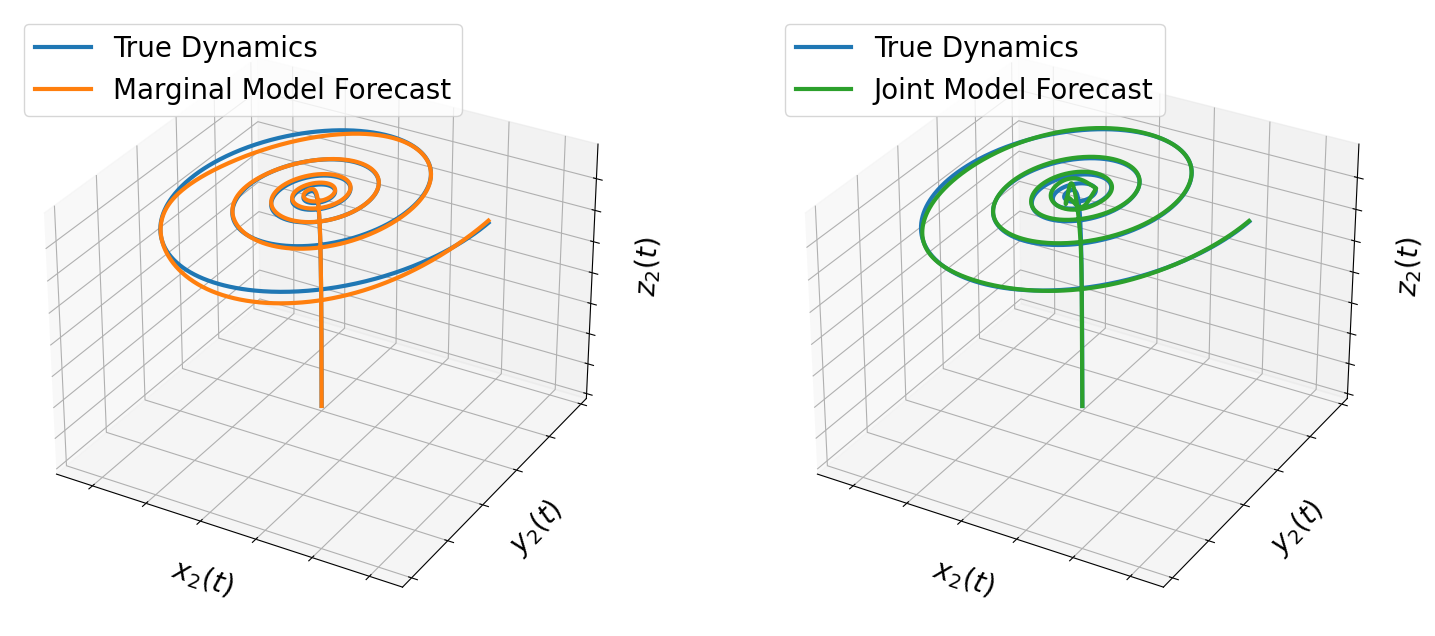

In [24]:
# Select three features for 3D phase space (e.g., indices 0, 1, 2)
x_idx, y_idx, z_idx = 0, 1, 2
time_idx = 3000

# Create subplots for 3D phase space
f = plt.figure(figsize=(18, 8), constrained_layout=True)

# First 3D subplot: True Dynamics vs Marginal Forecast
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax1.plot(effect[x_idx, :time_idx], effect[y_idx, :time_idx], effect[z_idx, :time_idx], label='True Dynamics', color='C0', linewidth=3)
ax1.plot(omega_marginal[x_idx, :time_idx], omega_marginal[y_idx, :time_idx], omega_marginal[z_idx, :time_idx], label='Marginal Model Forecast', color='C1', linewidth=3)
ax1.set_xlabel(rf'$x_2(t)$', size=20)
ax1.set_ylabel(rf'$y_2(t)$', size=20)
ax1.set_zlabel(rf'$z_2(t)$', size=20)
ax1.legend(loc='upper left', fontsize=20)

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

# Second 3D subplot: True Dynamics vs Joint Forecast
ax2 = f.add_subplot(1, 2, 2, projection='3d')
ax2.plot(effect[x_idx, :time_idx], effect[y_idx, :time_idx], effect[z_idx, :time_idx], label='True Dynamics', color='C0', linewidth=3)
ax2.plot(omega_joint[x_idx, :time_idx], omega_joint[y_idx, :time_idx], omega_joint[z_idx, :time_idx], label='Joint Model Forecast', color='C2', linewidth=3)
ax2.set_xlabel(rf'$x_2(t)$', size=20)
ax2.set_ylabel(rf'$y_2(t)$', size=20)
ax2.set_zlabel(rf'$z_2(t)$', size=20)
ax2.legend(loc='upper left', fontsize=20)

ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])

# Adjust tick size
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='z', labelsize=8)

plt.show()
f.savefig("docs/coupled_rossler_forecast_false_mlp.png", dpi=300, bbox_inches="tight");


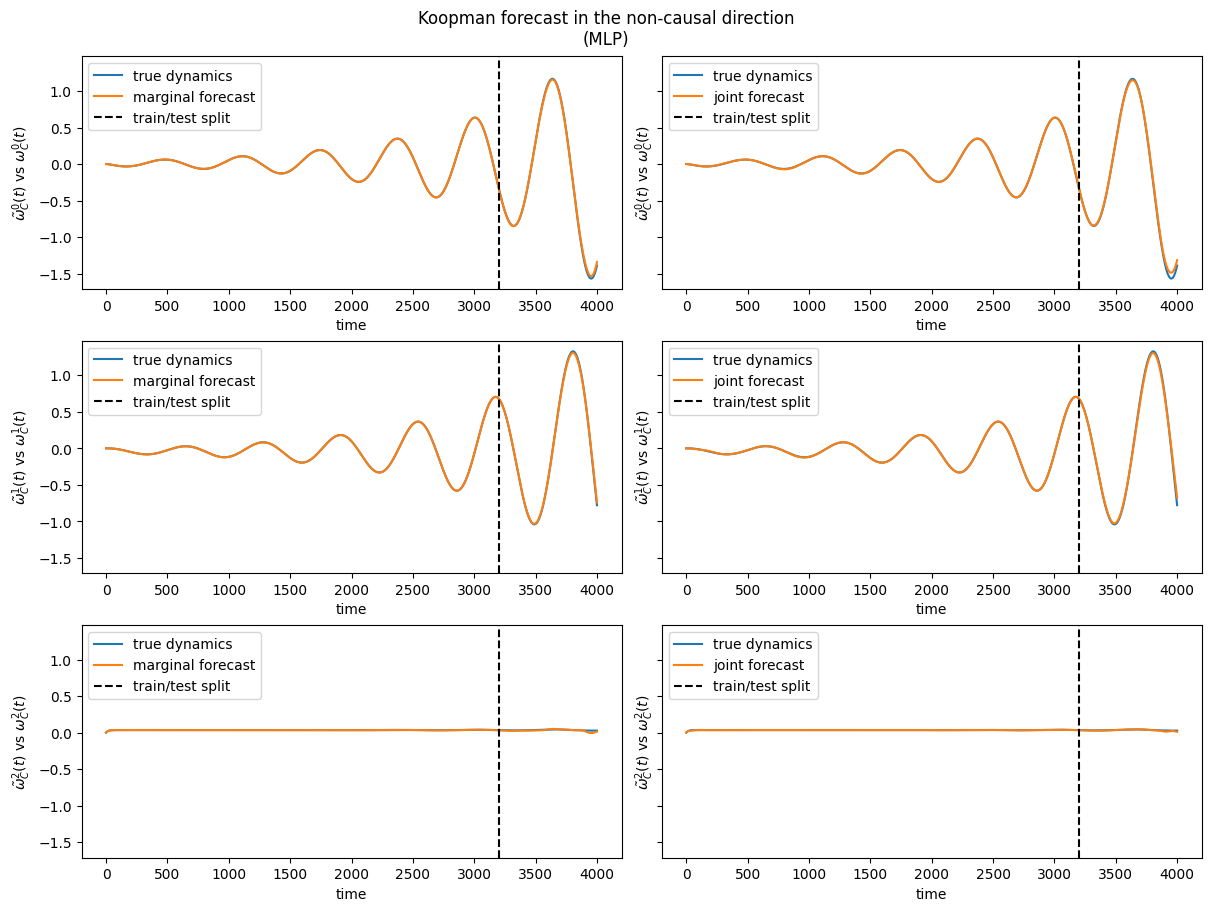

In [25]:
# Plot (conditional inference: non-causal)
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_C^{{{param_id}}}(t)$ vs $\omega_C^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_C^{{{param_id}}}(t)$ vs $\omega_C^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the non-causal direction\n(MLP)')
plt.show();


# 4. Additional Experiments

Here we perform additional experiments, mostly on ablating different kernel types.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.98it/s]


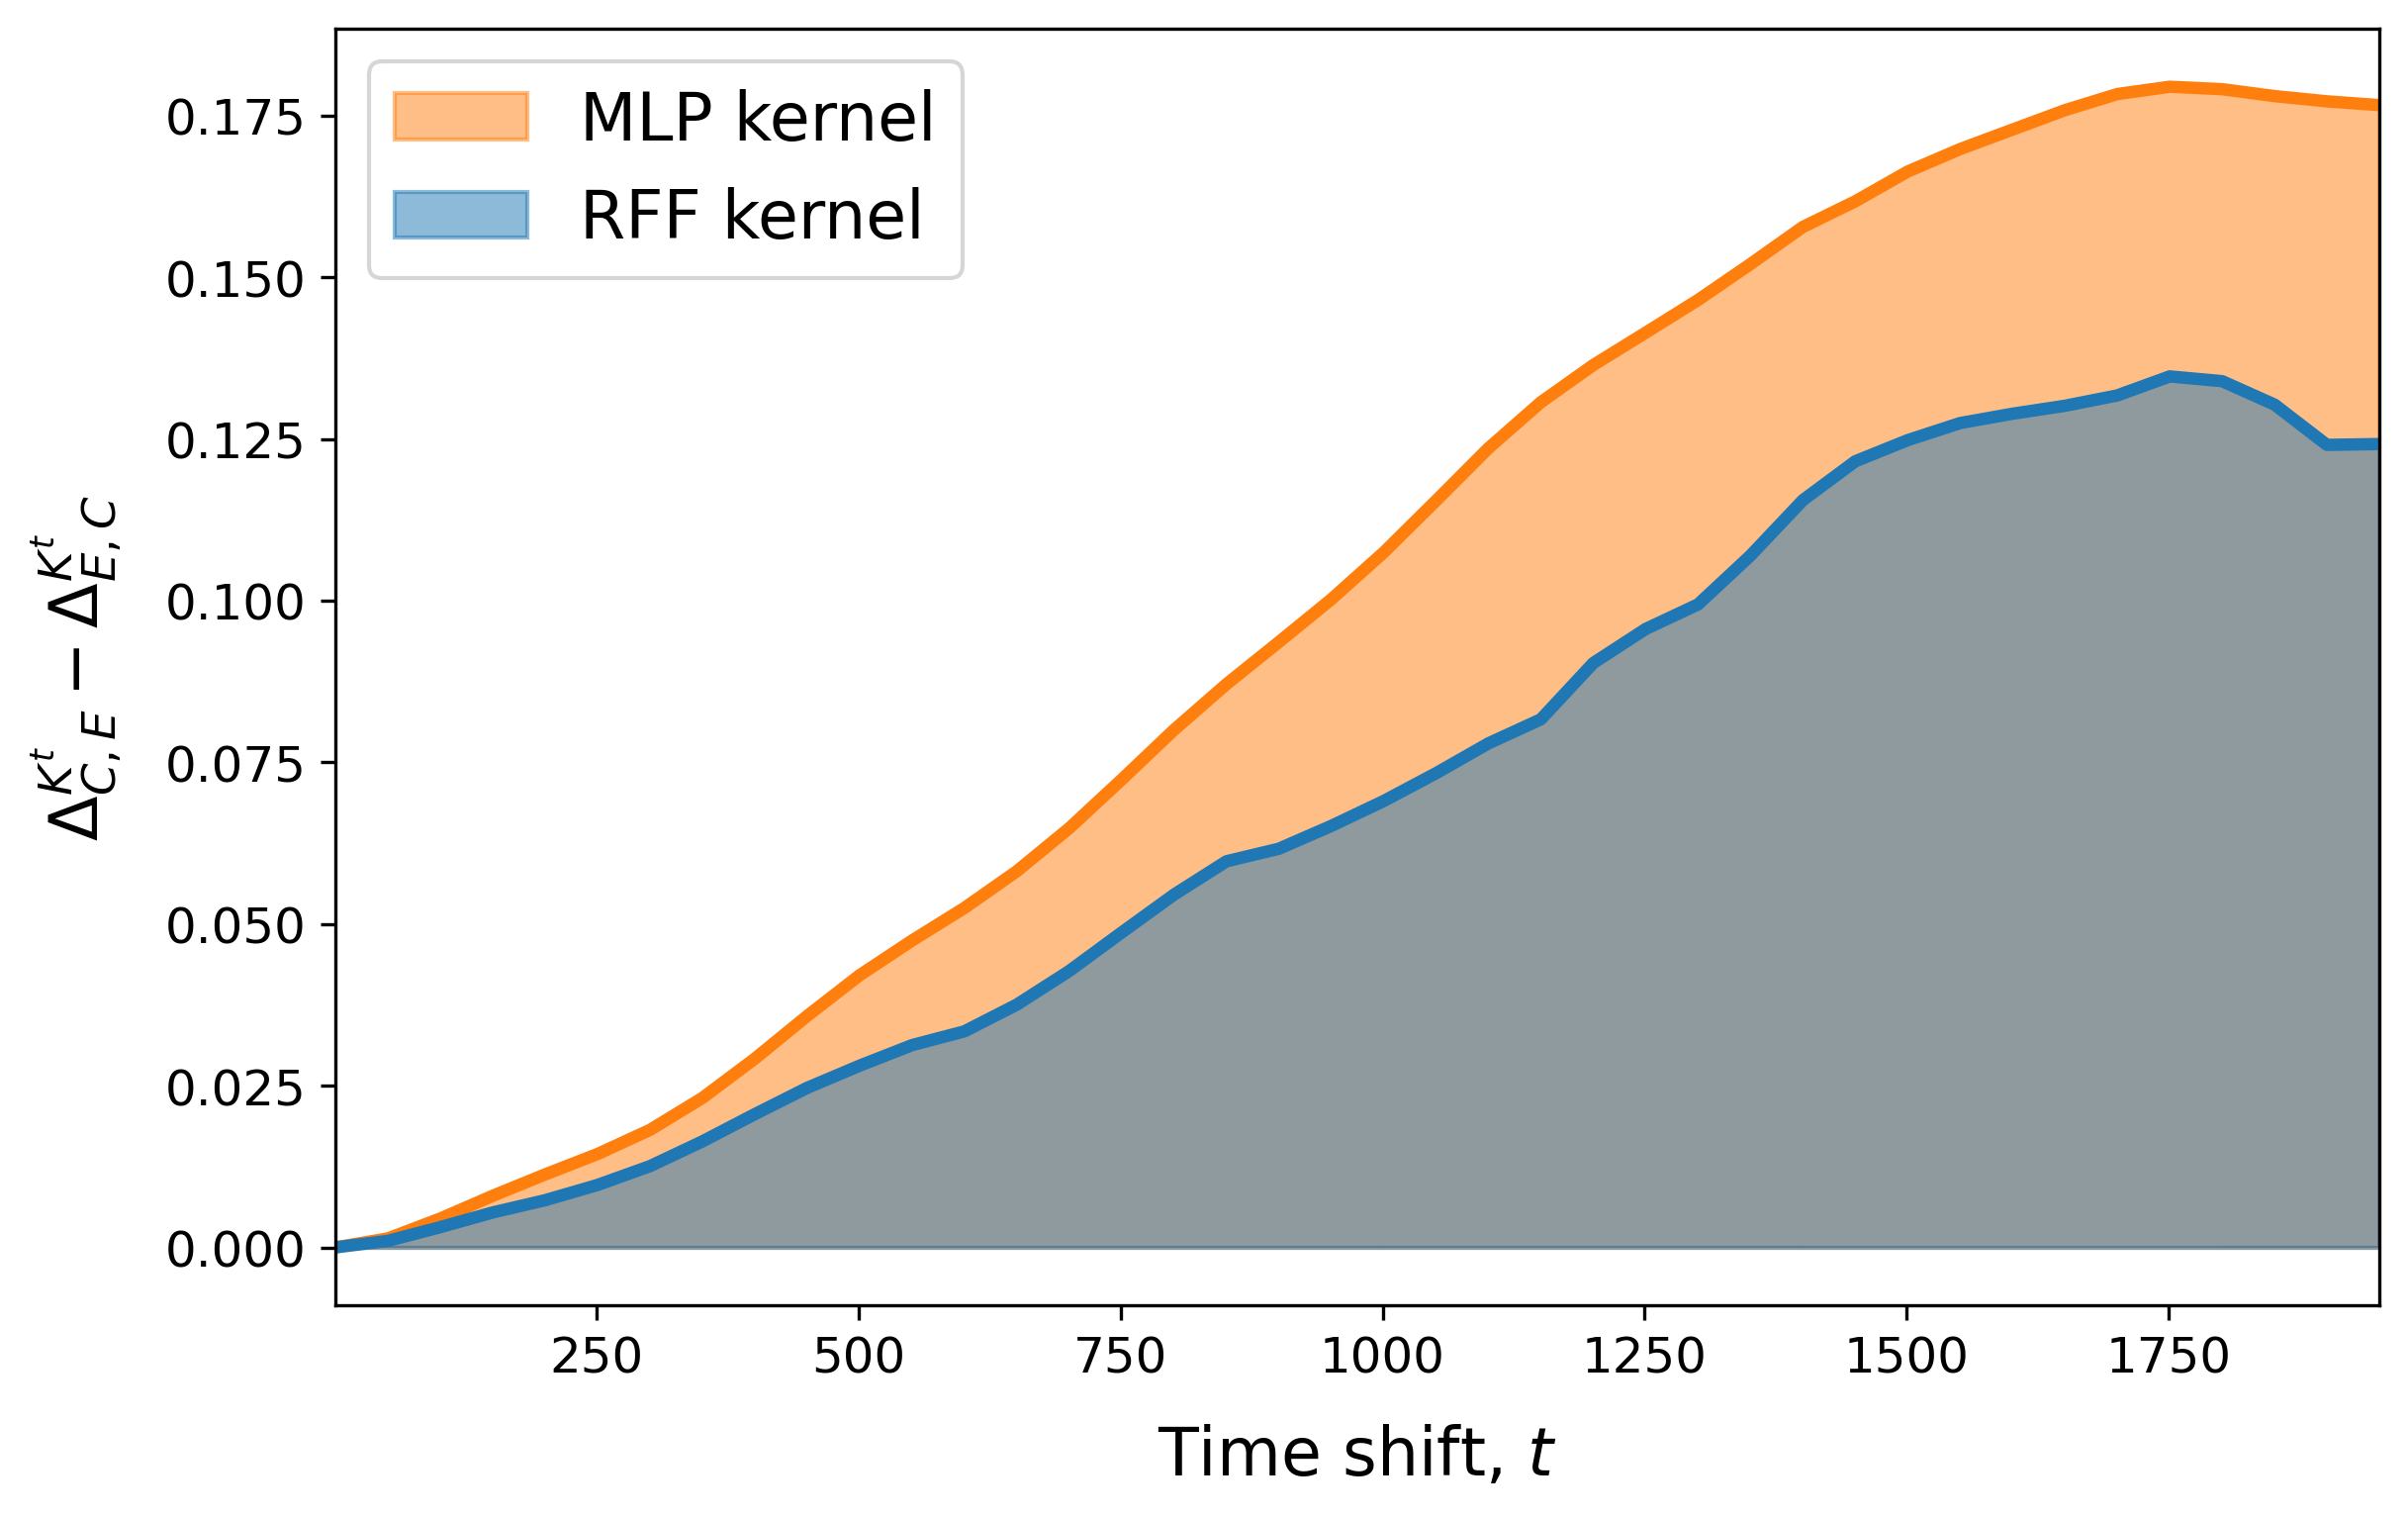

In [26]:
# Causal shift between kernel types
## RFF
causal_koopman_rff = Kausal(
    marginal_observable = RandomFourierFeatures(M=500),
    joint_observable = RandomFourierFeatures(M=500),
    cause = omega_2, 
    effect = omega_1
)
noncausal_koopman_rff = Kausal(
    marginal_observable = RandomFourierFeatures(M=500),
    joint_observable = RandomFourierFeatures(M=500),
    cause = omega_1, 
    effect = omega_2
)

causal_effect_rff = causal_koopman_rff.evaluate_multistep(time_shifts = time_shifts)
non_causal_effect_rff = noncausal_koopman_rff.evaluate_multistep(time_shifts = time_shifts)


## MLP
hidden_channels = [16, 32]
lr = 1e-2
epochs = 500

causal_koopman_mlp = Kausal(
    marginal_observable = MLPFeatures(in_channels=3, hidden_channels=hidden_channels, out_channels=3),
    joint_observable = MLPFeatures(in_channels=6, hidden_channels=hidden_channels, out_channels=3),
    cause = omega_2,
    effect = omega_1,
)


noncausal_koopman_mlp = Kausal(
    marginal_observable = MLPFeatures(in_channels=3, hidden_channels=hidden_channels, out_channels=3),
    joint_observable = MLPFeatures(in_channels=6, hidden_channels=hidden_channels, out_channels=3),
    cause = omega_1,
    effect = omega_2
)


_, _ = causal_koopman_mlp.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = n_train
)

_, _ = noncausal_koopman_mlp.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = n_train
)

causal_effect_mlp = causal_koopman_mlp.evaluate_multistep(time_shifts = time_shifts)
non_causal_effect_mlp = noncausal_koopman_mlp.evaluate_multistep(time_shifts = time_shifts)

# Plot causal shift
# NOTE: increasing causal error in the true causal direction as time dependency increases.
# NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E.

plt.rcParams.update({
    "font.size": 14,                # General font size
    "axes.titlesize": 16,           # Title font size
    "axes.labelsize": 16,           # Axis label font size
    "xtick.labelsize": 12,          # X-axis tick label size
    "ytick.labelsize": 12,          # Y-axis tick label size
    "legend.fontsize": 16,          # Legend font size
    "lines.linewidth": 3,           # Line width
    "figure.dpi": 300,              # Higher DPI for clearer output
})

f, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)

diff_rff = causal_effect_rff - non_causal_effect_rff
diff_mlp = causal_effect_mlp - non_causal_effect_mlp

# Plot the difference between causal and non-causal effects
ax.plot(time_shifts, causal_effect_mlp, linestyle='-', color='C1')
ax.plot(time_shifts, causal_effect_rff, linestyle='-', color='C0')

# Add shading to represent differences
ax.fill_between(time_shifts, causal_effect_mlp, non_causal_effect_mlp, color='C1', alpha=0.5, label='MLP kernel')
ax.fill_between(time_shifts, causal_effect_rff, non_causal_effect_rff, color='C0', alpha=0.5, label='RFF kernel')

ax.set_xlabel(r'Time shift, $t$', labelpad=10)
ax.set_xlim([time_shifts[0], time_shifts[-1]])
ax.set_ylabel(r'$\Delta^{K^t}_{C,E} - \Delta^{K^t}_{E,C}$', labelpad=10)
plt.legend()
plt.show()
f.savefig("docs/coupled_rossler_estimation.png", dpi=300, bbox_inches="tight");


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 66.60it/s]


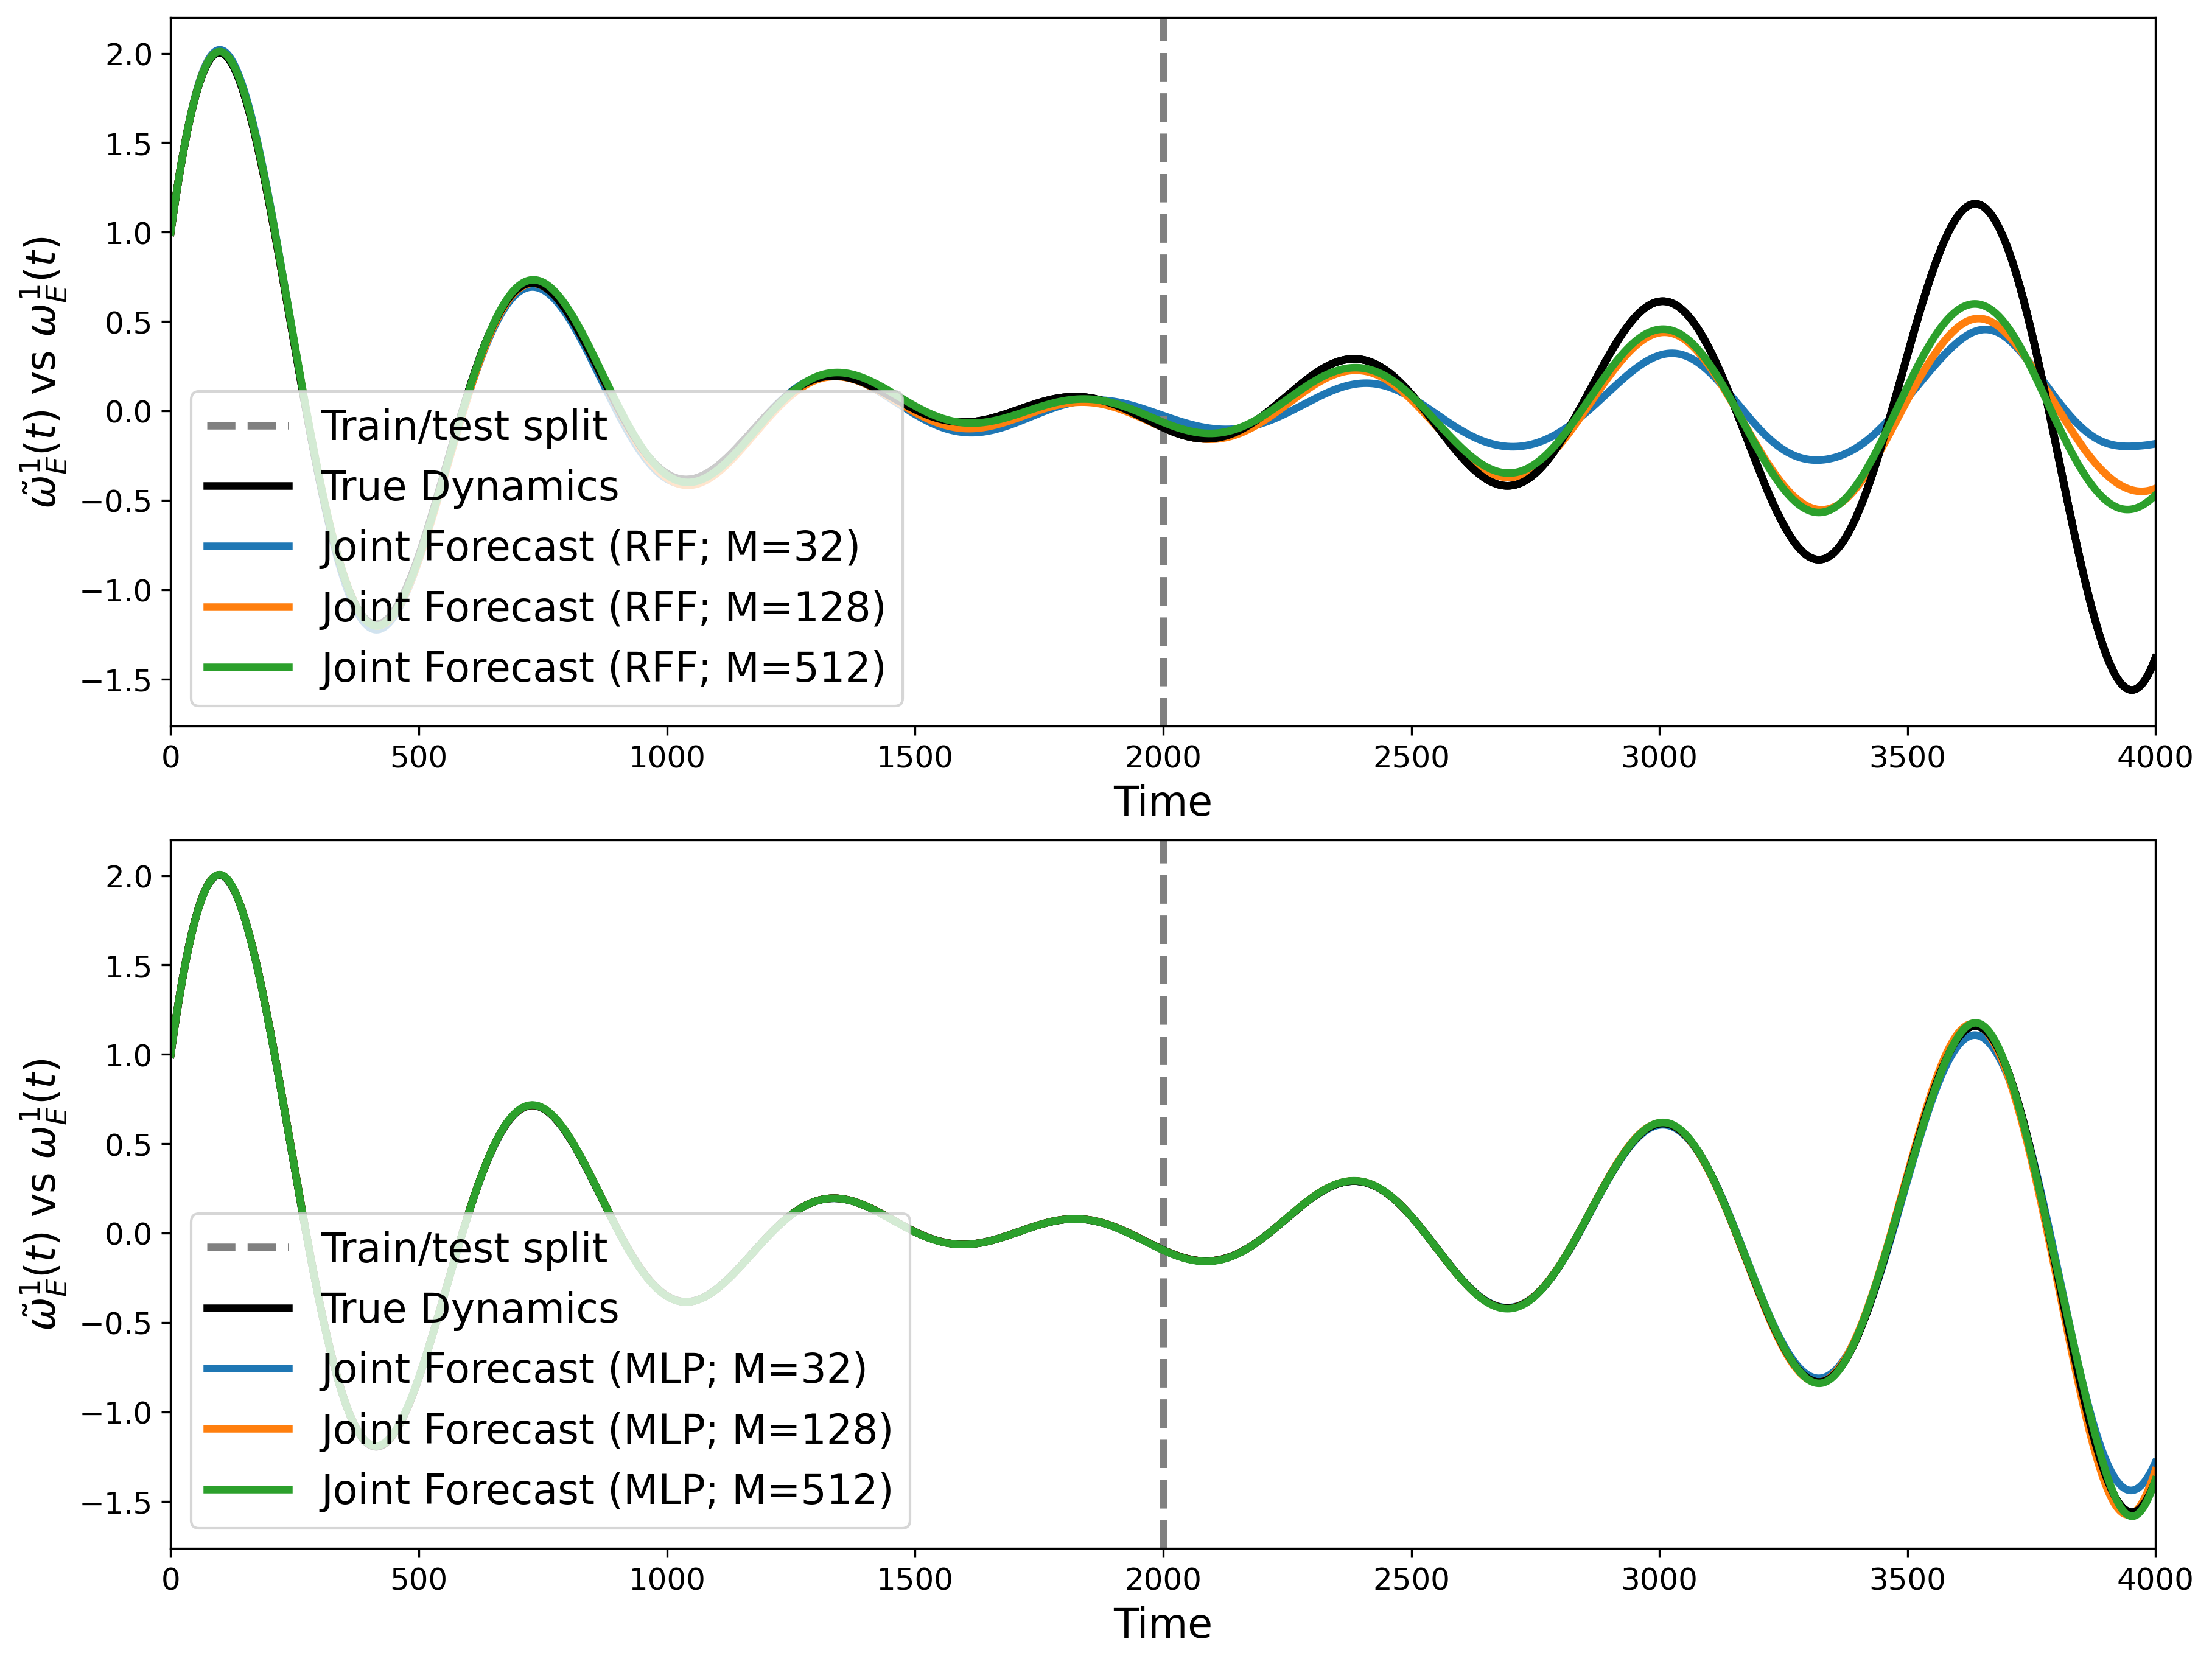

In [27]:
# Conditional forecasting (causal direction) between different kernel types and sizes
n_train = int(0.5 * steps)
cause = omega_2
effect = omega_1

f, ax = plt.subplots(2, 1, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

RFF_Ms = [32, 128, 512]
MLP_Ms = [[16, 32], [16, 128], [16, 512]]

lr = 1e-2
epochs = 500

param_idx = 0

for M_id, (RFF_M, MLP_M) in enumerate(zip(RFF_Ms, MLP_Ms)):

    ## RFF
    causal_koopman_rff = Kausal(
        marginal_observable=RandomFourierFeatures(M=RFF_M),
        joint_observable=RandomFourierFeatures(M=RFF_M),
        cause=omega_2,
        effect=omega_1,
    )

    _, omega_joint_rff = causal_koopman_rff.forecast(
        n_train=n_train,
        time_shift=1
    )

    ## MLP
    causal_koopman_mlp = Kausal(
        marginal_observable = MLPFeatures(in_channels=3, hidden_channels=MLP_M, out_channels=3),
        joint_observable = MLPFeatures(in_channels=6, hidden_channels=MLP_M, out_channels=3),
        cause=omega_2,
        effect=omega_1,
    )
    
    _, _ = causal_koopman_mlp.fit(
        n_train = n_train, 
        epochs = epochs, 
        lr = lr, 
        batch_size = n_train
    )

    with torch.no_grad():
        _, omega_joint_mlp = causal_koopman_mlp.forecast(
            n_train = n_train,
            time_shift = 1
        )


    # Plot (conditional inference: causal)
    # NOTE: better dynamic representation with data-driven MLP vs prescribed RFF
    
    ## Joint forecast (RFF)
    ax[0].axvline(n_train, color='grey', linestyle='--', label='Train/test split' if M_id == 0 else "") 
    ax[0].plot(effect[param_idx], label='True Dynamics' if M_id == 0 else "", color="black")
    ax[0].plot(omega_joint_rff[param_idx], label=f'Joint Forecast (RFF; M={RFF_M})')
    ax[0].set_xlim([0, steps])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel(rf'$\tilde{{\omega}}_E^{{1}}(t)$ vs $\omega_E^{{1}}(t)$')

    ## Joint forecast (MLP)
    ax[1].axvline(n_train, color='grey', linestyle='--', label='Train/test split' if M_id == 0 else "") 
    ax[1].plot(effect[param_idx], label='True Dynamics' if M_id == 0 else "", color="black")
    ax[1].plot(omega_joint_mlp[param_idx], label=f'Joint Forecast (MLP; M={MLP_M[-1]})')
    ax[1].set_xlim([0, steps])
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel(rf'$\tilde{{\omega}}_E^{{1}}(t)$ vs $\omega_E^{{1}}(t)$')


handles0, labels0 = ax[0].get_legend_handles_labels()
handles1, labels1 = ax[1].get_legend_handles_labels()
ax[0].legend(handles0, labels0, loc='lower left')
ax[1].legend(handles1, labels1, loc='lower left')
plt.show()
f.savefig("docs/coupled_rossler_ablate_M.png", dpi=300, bbox_inches="tight");


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 66.15it/s]


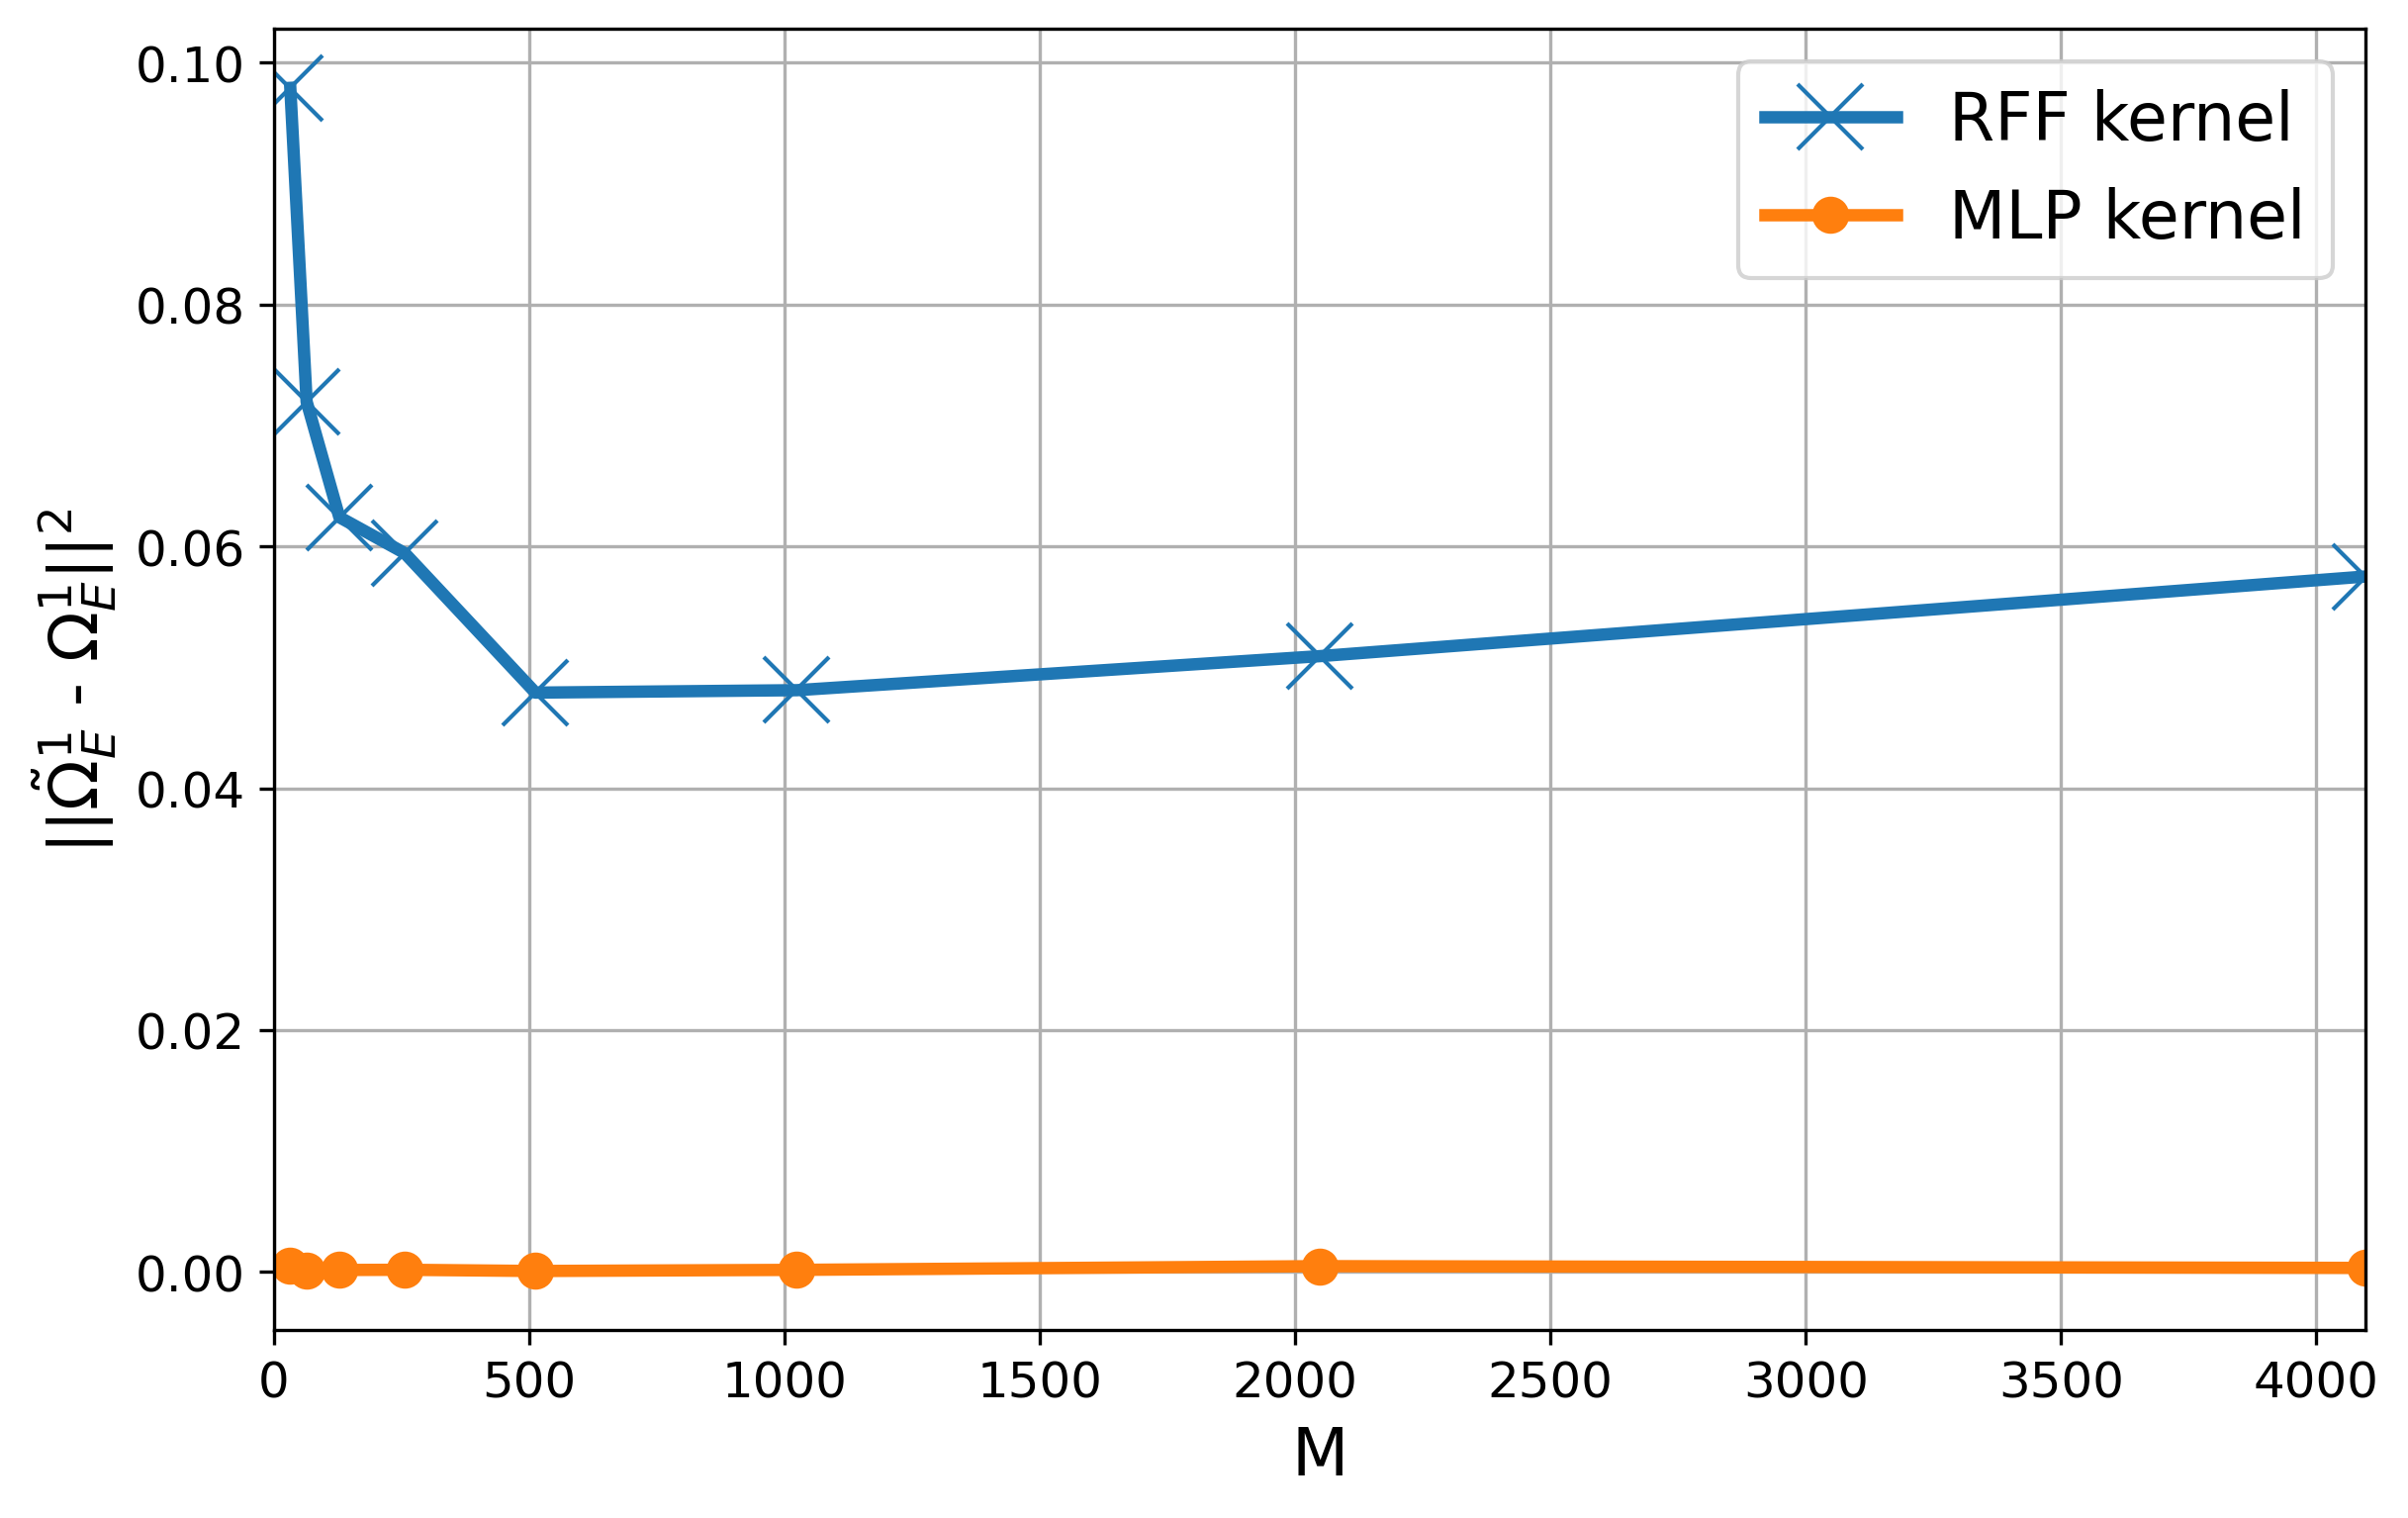

In [28]:
# Scaling law between kernel type and sizes
n_train = int(0.5 * steps)
cause = omega_2
effect = omega_1

Ms = [32, 64, 128, 256, 512, 1024, 2048, 4096]
lr = 1e-2
epochs = 500
param_idx = 0

rff_diffs, mlp_diffs = [], []

for M_id, M in enumerate(Ms):
    
    MLP_M = hidden_channels
    MLP_M[-1] = M

    ## RFF
    causal_koopman_rff = Kausal(
        marginal_observable = RandomFourierFeatures(M=M),
        joint_observable = RandomFourierFeatures(M=M),
        cause=omega_2,
        effect=omega_1,
    )

    _, omega_joint_rff = causal_koopman_rff.forecast(
        n_train=n_train,
        time_shift=1
    )

    ## MLP
    causal_koopman_mlp = Kausal(
        marginal_observable = MLPFeatures(in_channels=3, hidden_channels=MLP_M, out_channels=3),
        joint_observable = MLPFeatures(in_channels=6, hidden_channels=MLP_M, out_channels=3),
        cause=omega_2,
        effect=omega_1,
    )
    
    _, _ = causal_koopman_mlp.fit(
        n_train = n_train, 
        epochs = epochs, 
        lr = lr, 
        batch_size = n_train
    )

    with torch.no_grad():
        _, omega_joint_mlp = causal_koopman_mlp.forecast(
            n_train = n_train,
            time_shift = 1
        )

    ## Joint forecast difference with true dynamics 
    rff_diffs.append(F.mse_loss(omega_joint_rff[param_idx], effect[param_idx]))
    mlp_diffs.append(F.mse_loss(omega_joint_mlp[param_idx], effect[param_idx]))


# Plot 
# NOTE: scaling property showcasing how data-driven MLP better capture transformation in a linearized flow than prescribe RFF
f, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)
plt.plot(Ms, rff_diffs, marker='x', label='RFF kernel', markersize=16)
plt.plot(Ms, mlp_diffs, marker='.', label='MLP kernel', markersize=16)
plt.xlim([0, Ms[-1]])
plt.xlabel('M')
plt.ylabel(rf'$||\tilde{{\Omega}}_E^{{1}}$ - $\Omega_E^{{1}}||^2$')
plt.grid()
plt.legend()
plt.show()
f.savefig("docs/coupled_rossler_ablate_scale.png", dpi=300, bbox_inches="tight");
